In [1]:
!pip install gurobipy

### Imports utilizados:

In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.stats import gmean

%matplotlib inline

from markowitz import Markowitz

### Leitura dos dados de entrada:

In [2]:
df = pd.read_excel('seriehistorica10anos.xlsx')
df.fillna(method='ffill',inplace=True)
df.rename(columns={df.columns[0]: 'datas'}, inplace=True, errors='raise')

df['datas'] = pd.to_datetime(df['datas'])
df.set_index('datas', inplace = True)

df = df.replace(0, pd.NA).interpolate()

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].str.replace('[./-]', '', regex=True)
pf['APLICACAO_MINIMA'] = pf['APLICACAO_MINIMA'].str.replace('-', '0').str.replace('R\$ ','').str.replace('.', '').astype(float)

pf.set_index('CNPJ',inplace=True)
pf.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)
pf.reset_index(inplace=True)

CNPJ_dict_tipos = dict()
for cat in pf.CATEGORIA.unique():
    CNPJ_dict_tipos[cat] = pf.query('CATEGORIA == @cat').index.to_list()

CNPJ_list = list(pf.CNPJ)
df = df[CNPJ_list]

pf.set_index('CNPJ',inplace=True)

valorMinFundos = np.array(pf['APLICACAO_MINIMA'])

### Parâmetros de entrada do modelo:

In [3]:
minRetorno = 0.002
C = 100000
K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3

P_categorias = {
    'Ações': 0.0,
    'Cambial': 0.00,
    'Multimercados': 0.0,
    'Renda Fixa': 1.00
}

## Implementando uma janela rolante de testes:

In [4]:
tam_treinamento = 252
tam_teste = 126
inicio_treinamento = 0
final_treinamento = inicio_treinamento + tam_treinamento
inicio_teste = final_treinamento + 1
final_teste = inicio_teste + tam_teste

DF_retorno_completo = df.pct_change().dropna()

matriz_pesos = DF_retorno_completo.copy()
matriz_pesos = matriz_pesos * 0

hist = dict()

while(final_teste <= DF_retorno_completo.shape[0]):
    minRetorno = 0
    a_retorno = []
    a_risco = []
    a_sharpe = []

    RES = dict()
    k = 0
    
    DF_retorno_treinamento = DF_retorno_completo.iloc[inicio_treinamento:final_treinamento]
   
    sigma = (DF_retorno_treinamento.cov() * 252).to_numpy()
    media = (DF_retorno_treinamento + 1).apply(gmean)**252-1
    
    modelo = Markowitz(C, CNPJ_list, CNPJ_dict_tipos, P_min, P_max, P_categorias, K_min, K_max, 
       valorMinFundos, sigma, media, minRetorno)
    
    tempo_init = time.time()
    carteiras, idx_max_sharpe = modelo.solve_fronteira(0.0, 0.2, 0.002)
    carteira = carteiras[idx_max_sharpe]
    
    #Carteira = modelo.solve()
    print('Tempo total:', time.time() - tempo_init, 's')

    carteira.exibir(C)

    hist[str(inicio_treinamento), str(final_treinamento)] = carteira
    print('Resultado referente a slice: ', inicio_treinamento, '-', final_treinamento)
    print('\n')
    print('###############################################')
    print('\n')

    for idx, cnpj_loop in enumerate(carteira.CNPJ_list):
        matriz_pesos[cnpj_loop][inicio_teste:final_teste] = carteira.porcentagem[idx]
    
    inicio_treinamento += tam_teste
    final_treinamento += tam_teste
    
    inicio_teste += tam_teste
    final_teste += tam_teste

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic
Changed value of parameter TimeLimit to 15.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Tempo total: 22.58429193496704 s
Retorno esperado --> 10.4%
Risco estimado --> 0.09%
Fundo 40 (07900255000150) 	 Peso: 22.07% 	 Valor: R$ 22070.64
Fundo 82 (10326625000100) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 118 (10783480000168) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 140 (73970642000197) 	 Peso: 10.13% 	 Valor: R$ 10134.51
Fundo 152 (12923387000137) 	 Peso: 7.79% 	 Valor: R$ 7794.85
Resultado referente a slice:  0 - 252


###############################################


Changed value of parameter TimeLimit to 15.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Tempo total: 23.105321645736694 s
Retorno esperado --> 8.4%
Risco estimado --> 0.08%
Fundo 40 (07900255000150) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 82 (10326625000100) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 135 (136

Changed value of parameter TimeLimit to 15.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Tempo total: 23.577348709106445 s
Retorno esperado --> 6.6%
Risco estimado --> 0.04%
Fundo 4 (02539921000152) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 16 (04899128000190) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 74 (09543255000175) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 76 (09720734000110) 	 Peso: 28.6% 	 Valor: R$ 28598.61
Fundo 140 (73970642000197) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 152 (12923387000137) 	 Peso: 26.4% 	 Valor: R$ 26401.39
Resultado referente a slice:  1764 - 2016


###############################################


Changed value of parameter TimeLimit to 15.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Nenhuma solucao encontrada!
Tempo total: 5.089291095733643 s
Retorno esperado --> 5.8%
Risco estimado --> 0.23%
Fundo 32 (02603461000184) 	 Peso: 24.63% 	 Valor: R$ 24633.35
Fundo 40 (07900255000150) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 60 (09215250000113) 	 Peso: 5.0% 	 Valor

2012-09-04    1.000000
2012-09-05    1.000295
2012-09-06    1.000588
2012-09-10    1.000871
2012-09-11    1.001169
                ...   
2021-08-30    2.061710
2021-08-31    2.052578
2021-09-01    2.054912
2021-09-02    2.045075
2021-09-03    2.042790
Name: Retorno Acumulado, Length: 2269, dtype: float64

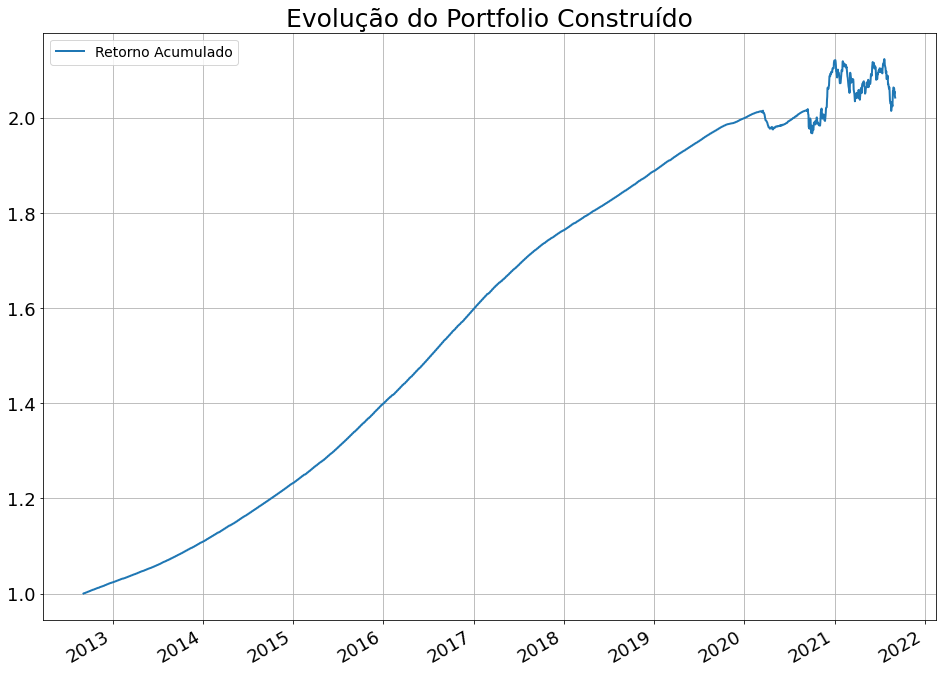

In [5]:
retorno_perc_carteira = (matriz_pesos * DF_retorno_completo).sum(axis=1)[tam_treinamento:]

retorno_acum_carteira = (retorno_perc_carteira + 1).cumprod()
retorno_acum_carteira.name = 'Retorno Acumulado'
retorno_acum_carteira.rename_axis(None, inplace=True)
fig = retorno_acum_carteira.plot(figsize = (16,12), grid=True, fontsize = 18, linewidth=2.0)
plt.legend(loc='upper left', fontsize = 14)
plt.title('Evolução do Portfolio Construído', fontdict = {'fontsize' : 25})
retorno_acum_carteira


In [6]:
resultados = list()
    
for idx_loop, periodo in enumerate(hist.keys()):
    init, fim = periodo
    resultados.append([round(hist[init, fim].Retorno * 100, 2), round( (((retorno_perc_carteira[int(init):int(fim) - 126] + 1).prod()**2) - 1) * 100, 2)])

resultados = pd.DataFrame(resultados, columns = ['Exp.', 'Real'])
resultados = resultados.applymap(lambda x: str(x) + '%')

resultados

#resultados.to_csv('RES_MODERADO_10.csv')
#resultados.to_excel('RES_CONSERVADOR_10.xlsx')

,Exp.,Real
0,10.4%,7.38%
1,8.4%,7.93%
2,7.63%,10.01%
3,8.88%,11.09%
4,10.45%,11.58%
5,11.29%,13.59%
6,13.0%,14.35%
7,14.0%,14.54%
8,14.11%,13.67%
9,14.2%,11.03%
